<font size=5>**Filtrar anotações com baixa qualidade para o dataset final**</font>

Aqui, iremos montar um dataset com base nas anotações da primeira parte de cada etapa (treino 1, treino 2, prática). As análises usando a segunda e a terceira parte (precedente e doutrina) serão feitas em outro notebook.

<font size=3>**Resultados Esperados**</font>

1. Coleção de arquivos NER.csv com todas as decisões anotadas da etapa prática

2. Código utilizado

Anteriormente, foi analisada a concordância entre anotadores para cada treino e para a etapa prática.
Com aqueles dados, iremos agora consolidar uma base de dados que remova as anotações de baixa qualidade.

**Parte 1:** Usando o kappa e as percentagens do treino 1 e do treino 2 como referências, vamos remover as anotações de baixa qualidade.

Tabela de Kappas


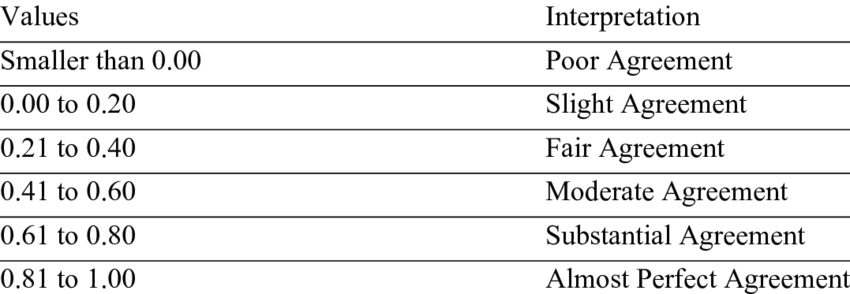

**Parte 2:** Usando majority voting para cada texto da etapa prática com base apenas nas anotações de alta qualidade, iremos montar uma nova base de dados.

<center> <font size=4><b>Majority Voting</b></font> </center>

<br>
<br>
<br>
<center>
    O Plenário desta Corte, em 24/11/2010, no julgamento da <mark style="background: cyan; border-radius: 0.2em;margin:0.1em">ADC nº 16/DF</mark>, Relator o Ministro Cezar ...</center>
<br>
<center>
$\qquad\qquad\qquad\qquad\qquad \qquad\qquad\qquad\quad\updownarrow\qquad\qquad\qquad\qquad \updownarrow$
</center>
<br>
<center>
    O Plenário desta Corte, em 24/11/2010, no julgamento da <mark style="background: cyan; border-radius: 0.2em;margin:0.1em">ADC nº 16/DF</mark>, Relator o <mark style="background:#7cf708; border-radius: 0.2em;margin:0.1em">Ministro Cezar </mark>...</center>
<br>
<center>
$\qquad\qquad\qquad\qquad\qquad \qquad\qquad\qquad\quad\updownarrow\qquad\qquad\qquad\qquad \updownarrow$
</center>
<br>
<center>
    O Plenário desta Corte, em 24/11/2010, no julgamento da <mark style="background: cyan; border-radius: 0.2em;margin:0.1em">ADC nº 16/DF</mark>, Relator o Ministro Cezar ...</center>
<br>
<center>
$\qquad\qquad\qquad\qquad\qquad \qquad\qquad\qquad\quad\updownarrow\qquad\qquad\qquad\qquad \updownarrow$
</center>
<br>
<center>
    O Plenário desta Corte, em 24/11/2010, no julgamento da ADC nº 16/DF, Relator o <mark style="background:#7cf708; border-radius: 0.2em;margin:0.1em">Ministro Cezar </mark>...</center>
$-------------------------------------------------------$

**Resultado:**
<center>
    O Plenário desta Corte, em 24/11/2010, no julgamento da <mark style="background: cyan; border-radius: 0.2em;margin:0.1em">ADC nº 16/DF</mark>, Relator o Ministro Cezar ...</center>

É necessário maioria ABSOLUTA para passar, ou seja, mais da metade dos votos.

In [21]:
import glob
import os


import tqdm
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt

<font size=5>**0. Funções Auxiliares**</font>

<font size=4>**0.1.Funções de preprocessamento**</font>

In [22]:
def create_annot_files_df(phase, data_path='dados'):
    """
    Retorna dataframe com informações sobre arquivos anotados.
    phase é a fase de anotação que deve ser gerada
    data_path é pasta onde arquivos anotados se encontram
    """
    files = glob.glob(
        data_path + "/*/" + phase + '/Documentos/*.csv'
    )
    split_files = files

    data = list()

    for fl in files:
        sl = fl.split('/')
        data.append((sl[1], sl[-1].split('.')[0], fl, sl[2]))

    df = pd.DataFrame(
        data=data,
        columns=['anotador', 'documento', 'arquivo', 'fase']
    )
    return df

In [23]:
def analise_por_label(dataframe):
    
    kappa_l = list()
    concord_l = list()
    
    labels = ['Doutrina', 'Precedente', 'Pessoa', 'Ref. Legislativa']
    
    for l in labels:
#         q = f" Tag1 == 'I_{l}' or Tag1 == 'B_{l}' or Tag2 == 'I_{l}' or Tag2 == 'B_{l}'"
        q = f" Tag1 == '{l}' or Tag2 == '{l}'"
        df = dataframe.query(q)
        # df = dataframe
        y1_temp = df.Tag1.values
        y2_temp = df.Tag2.values
        kappa = sklearn.metrics.cohen_kappa_score(y1_temp, y2_temp)
        concord_percent = (y1_temp == y2_temp).sum()/y1_temp.size
        kappa_l.append(kappa)
        concord_l.append(concord_percent)
        kappa_l = list(np.nan_to_num(kappa_l, copy=True))
    return kappa_l, concord_l

In [24]:
def analise_dados(dataframe):
    """
    Função para agrupar todas as análises necessárias
    """
    
    y1 = dataframe.Tag1.values
    y2 = dataframe.Tag2.values
    
    # Calculando cohen's kappa, percentuais totais e por label
    kappa = sklearn.metrics.cohen_kappa_score(y1, y2)
    concord_percent = (y1 == y2).sum()/y1.size
    
    # Calculando Kappa e Percentual por tipo de anotação
    kappa_l, concord_l = analise_por_label(dataframe)
    
    
    # Adicionando valor geral ao início da lista
    kappa_l = [kappa] + kappa_l
    concord_l = [concord_percent] + concord_l
        
    
    return kappa_l, concord_l

# Pegando arquivos de dados

Vamos assumir que todos os dados com a anotação de cada arquivo se encontram em:

<center><font color='red' >./dados/*/[PRATICA_ETAPA_1]/Documentos/**.csv</font></center>

Que são os arquivos de anotação dos textos. No lugar de * , entra o login do aluno, enquanto que no lugar de ** entra cada arquivo anotado pelo aluno. 

Gerando DataFrame com arquivos anotados por cada anotador

In [25]:
df_annot = create_annot_files_df('[[]PRATICA_ETAPA_1[]]')

df_annot.head(2)

,anotador,documento,arquivo,fase
0,181300039,20170801_ADI_5253_312309137,dados/181300039/[PRATICA_ETAPA_1]/Documentos/2...,[PRATICA_ETAPA_1]
1,181300039,20180529_ARE_1122534_314445283,dados/181300039/[PRATICA_ETAPA_1]/Documentos/2...,[PRATICA_ETAPA_1]


Gerando lista de alunos que realizaram anotação e número de anotadores

In [26]:
# Pegando uma lista de todos os alunos que fizeram a anotação
students = df_annot.anotador.unique()

# Salvando o número de alunos anotadores
size = len(students)

Gerando matriz com merge em documento anotado para saber se há overlap entre anotadores

In [28]:
# Gerando matriz com merge em documento anotado para saber se há overlap entre anotadores
df_overlap = df_annot.merge(df_annot, on='documento', suffixes=('_x', '_y'))

In [29]:
# Corrigindo problema com o primeiro treino de Anotação
mapping = {"B_Doutrinador":"B_Doutrina", "I_Doutrinador":"I_Doutrina"}

# Calculando as métricas

In [31]:
# Inicializando as variáveis na memória onde salvar os resultados
# Utilizando matriz tridimensional, com a terceira dimensão contendo a 
labels = ['Geral', 'Doutrina', 'Precedente', 'Pessoa', 'Ref. Legislativa']

kappa_matrix = np.empty((size,size, len(labels)))
kappa_matrix.fill(np.nan)
percent_matrix = np.empty((size,size, len(labels)))
percent_matrix.fill(np.nan)

# Percorrendo todos os possíveis pares de alunos
for n in tqdm.tqdm_notebook(range(size)):
    for m in range(size):     
        
        # checando se há overlap entre eles
        df_pair = df_overlap.query('anotador_x == @students[@n] and anotador_y == @students[@m]')
        
        # Se não houve overlap pular par
        if df_pair.shape[0] == 0:
            continue

        # Inicializando dataframe com tags
        df_tags = pd.DataFrame()
            
        # Iterando sobre overlap
        for i, row in df_pair.iterrows():
            
            # Pegando nome dos arquivos
            filename1 = row['arquivo_x']
            filename2 = row['arquivo_y']

            # Pegando os arquivos de anotação com aquele nome
            df1_temp = pd.read_csv(filename1, delimiter=';', na_values='NaN')
            df1_temp.replace(mapping, inplace=True)
            df2_temp = pd.read_csv(filename2, delimiter=';', na_values='NaN')
            df2_temp.replace(mapping, inplace=True)
            
            # Criando coluna com tag do segundo anotador
            df1_temp['Tag2'] = df2_temp.Tag
            
            # Mantendo apenas tag anotados por ao menos um dos anotadores
            df1_temp.query('Tag != "O" or Tag2 != "O"', inplace=True)
            df1_temp.columns = ['Token', 'Tag1', 'Tag2']

            # Concatenando o vetor de tags da vez com os antigos
            df_tags = pd.concat([df_tags, df1_temp]) 
            
        # Limpando possíveis erros nas tags
        df_tags.dropna(inplace=True)
               
        df_tags.replace(
            {
                'B_Precedente': 'Precedente',
                'I_Precedente': 'Precedente',
                'B_Pessoa': 'Pessoa',
                'I_Pessoa': 'Pessoa',
                'B_Ref. Legislativa': 'Ref. Legislativa',
                'I_Ref. Legislativa': 'Ref. Legislativa',
                'B_Doutrina': 'Doutrina',
                'I_Doutrina': 'Doutrina'
            },
            inplace=True
            )
        
        # Calculando as concordâncias caso hajam arquivos em comum
        kappas, percents = analise_dados(df_tags)
        
        # Salvando os resultados
        kappa_matrix[n, m, :] = kappas
        percent_matrix[n, m, :] = percents

/home/alexandre/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:576: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


## Visualizando resultados

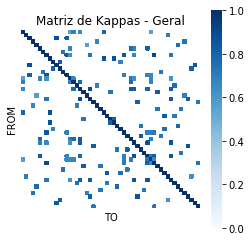

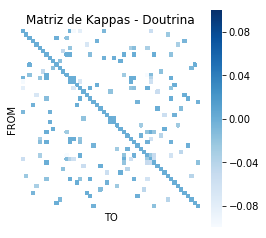

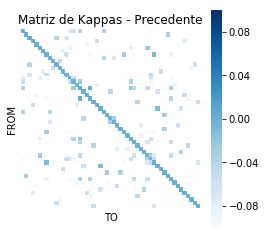

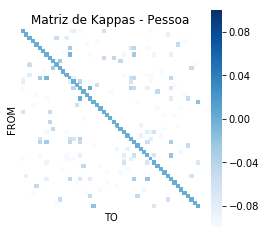

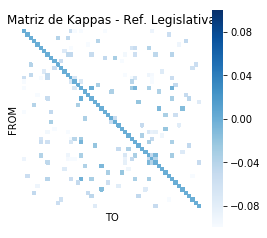

In [32]:
for i, l in enumerate(labels):
    # Plotando a matriz de kappas sem legenda
    # Abrindo a figura e o eixo
    fig, ax = plt.subplots(figsize=(4,4))

    # Desenhando o heatmap
    # sns.heatmap(kappa_matrix, annot=True, ax=ax, xticklabels=ticks, yticklabels=ticks, square=True, cmap='Blues')
    sns.heatmap(kappa_matrix[:, :, i], annot=False, ax=ax, xticklabels=[], yticklabels=[], square=True, cmap='Blues', vmin=0)

    # Definindo título dos eixos
    ax.set_title('Matriz de Kappas - ' + l)
    ax.set_ylabel('FROM')
    ax.set_xlabel('TO')

    #Mostrando o gráfico
    plt.show()

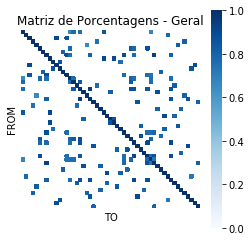

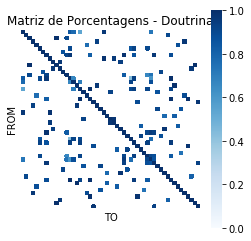

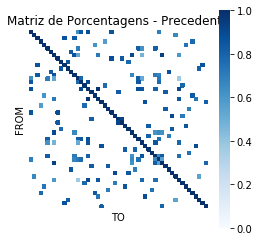

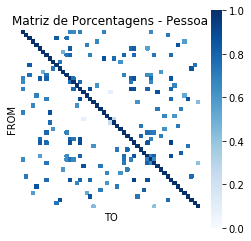

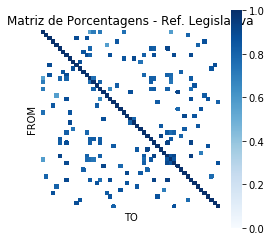

In [33]:
for i, l in enumerate(labels):
    # Plotando a matriz de percentagens
    # Abrindo a figura e o eixo
    fig, ax = plt.subplots(figsize=(4,4))

    # Pegando só a matricula dos alunos
    #ticks = [i.split('/')[-1] for i in students]

    # Desenhando o heatmap
    # sns.heatmap(percent_matrix, annot=True,  ax=ax, xticklabels=ticks, yticklabels=ticks, square=True, cmap='Blues')
    sns.heatmap(percent_matrix[:, :, i], annot=False,  ax=ax, xticklabels=[], yticklabels=[], square=True, cmap='Blues', vmin=0)

    # Definindo título dos eixos
    ax.set_title('Matriz de Porcentagens - '+ l)
    ax.set_ylabel('FROM')
    ax.set_xlabel('TO')

    #Mostrando o gráfico
    plt.show()

# Estatísticas do Kappa

In [34]:
# Criando a lista com os kappas médios
av_kappas = list()

for n, s in enumerate(students):
    
    k = list()
    
    for i, l in enumerate(labels):
        
        # Pegando a n-ésima linha da matriz de kappas com a label i
        kps = kappa_matrix[n, :, i]
        
        # Removendo o próprio anotador
        kps = np.delete(kps, n)
        
        # Calculando o kappa médio (tira todos os 0s da linha)
        k.append(kps[(kps == kps)].mean())
        
    # Populando a lista de kappas médios
    av_kappas.append(
        (students[n], ) + tuple(k)
    ) 

# Dataframe de kappas médios
av_kappas_df = pd.DataFrame(data=av_kappas, columns=['anotador'] + labels)

# Organizando por kappa médio
av_kappas_df.sort_values('Geral', ascending=False, inplace=True)

# Vendo os maiores kappas
av_kappas_df.head(20)

,anotador,Geral,Doutrina,Precedente,Pessoa,Ref. Legislativa
8,181300026,0.872363,-0.001626,-0.054781,-0.048765,-0.039084
10,181300014,0.859979,-0.000659,-0.047356,-0.080565,-0.046967
2,181300904,0.845785,-0.009421,-0.052506,-0.067015,-0.042510
51,171300011,0.843008,0.000000,-0.055731,-0.105855,-0.055466
49,181300072,0.841130,-0.000676,-0.069037,-0.050826,-0.045777
34,172300501,0.840638,-0.002839,-0.042579,-0.084442,-0.034214
27,181300052,0.840482,-0.001019,-0.047336,-0.094500,-0.042403
24,171300023,0.835736,-0.005864,-0.037201,-0.056995,-0.076662
11,181300055,0.818745,-0.012289,-0.068427,-0.038153,-0.056581
20,181300004,0.818467,-0.003349,-0.062704,-0.061335,-0.031752


In [35]:
av_kappas_df.query('Geral > 0.75').shape[0]

28

In [36]:
av_kappas_df.tail()

,anotador,Geral,Doutrina,Precedente,Pessoa,Ref. Legislativa
38,vinicius,0.669856,-0.037748,-0.078154,-0.120288,-0.079357
4,181300037,0.667956,-0.050007,-0.096730,-0.080142,-0.143334
0,181300039,0.658386,-0.049807,-0.063212,-0.103803,-0.104994
14,pillar,0.645749,-0.008062,-0.112615,-0.058657,-0.074370
19,181300022,0.634286,-0.034058,-0.071260,-0.179164,-0.123147


## Distribuição de kappas

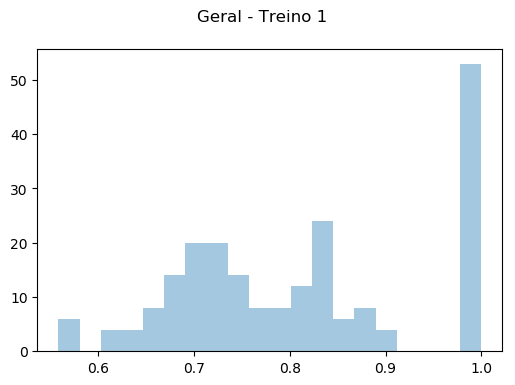

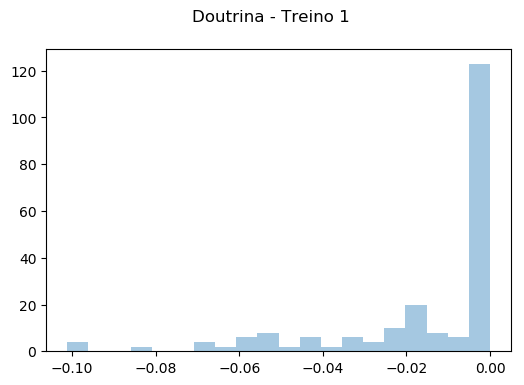

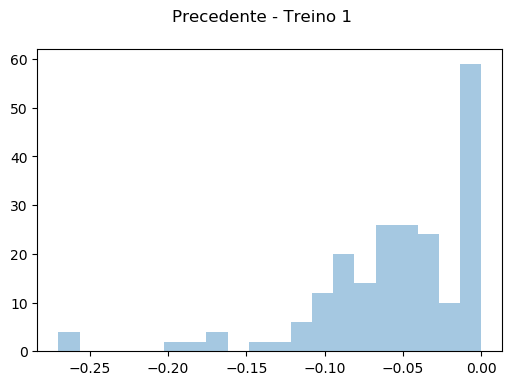

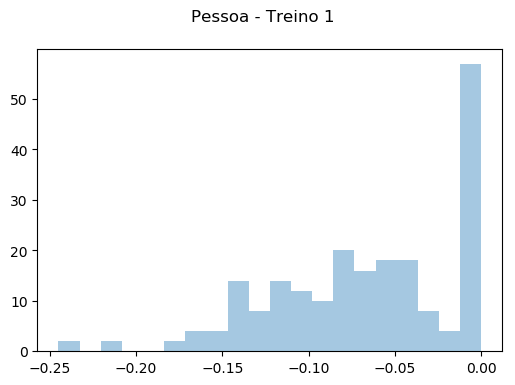

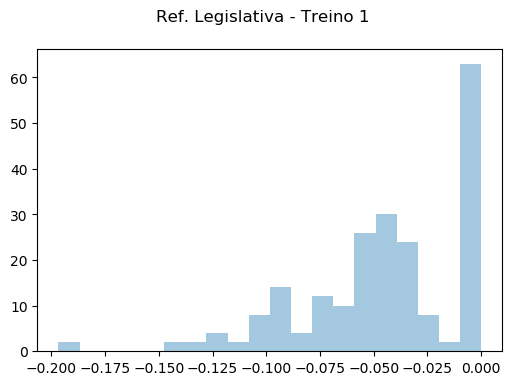

In [37]:
for i, l in enumerate(labels):
    
    fig, ax = plt.subplots(figsize=(6,4), dpi=100)
    
    sns.distplot(
        kappa_matrix[:,:,i][kappa_matrix[:,:,i] == kappa_matrix[:,:,i]],
        kde=False,
        bins=20,
        ax=ax
    )
    plt.suptitle(l+" - Treino 1")
    plt.show()
    

## Como mudaria o visual dos kappas se reorganizássemos?

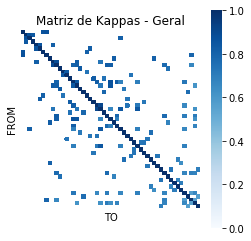

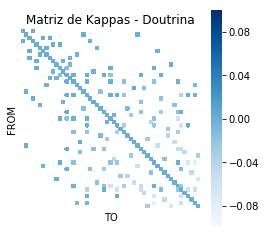

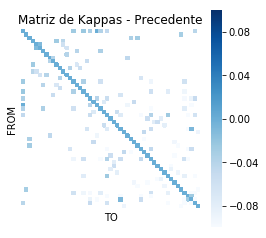

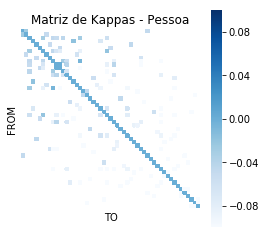

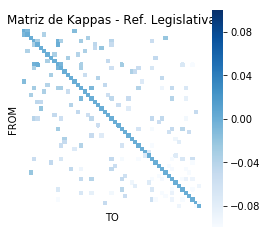

In [38]:
for i, l in enumerate(labels):
    # Plotando a matriz de kappas sem legenda
    # Abrindo a figura e o eixo
    fig, ax = plt.subplots(figsize=(4,4))

    av_kappas_df.sort_values(l, ascending=False, inplace=True)

    new_order = av_kappas_df.index
    
    reorganize_kappa = kappa_matrix[:, new_order, i][new_order]
    
    # Desenhando o heatmap
    # sns.heatmap(kappa_matrix, annot=True, ax=ax, xticklabels=ticks, yticklabels=ticks, square=True, cmap='Blues')
    sns.heatmap(reorganize_kappa[:, :], annot=False, ax=ax, xticklabels=[], yticklabels=[], square=True, cmap='Blues', vmin=0)

    # Definindo título dos eixos
    ax.set_title('Matriz de Kappas - ' + l)
    ax.set_ylabel('FROM')
    ax.set_xlabel('TO')

    #Mostrando o gráfico
    plt.show()

## Vendo a estatística dos kappas

In [39]:
# Criando a lista com os kappas std
std_kappas = list()

for n, s in enumerate(students):
    
    k = list()
    
    for i, l in enumerate(labels):
        
        # Pegando a n-ésima linha da matriz de kappas com a label i
        kps = kappa_matrix[n, :, i]
        
        # Removendo o próprio anotador
        kps = np.delete(kps, n)
        
        # Calculando o kappa std (tira todos os 0s da linha, e tira o próprio anotador)
        k.append(kps[(kps == kps)].std())
        
    # Populando a lista de kappas std
    std_kappas.append(
        (students[n], ) + tuple(k)
    ) 

# Dataframe de kappas std
std_kappas_df = pd.DataFrame(data=std_kappas, columns=['anotador'] + labels)

In [40]:
av_kappas_df.sort_values("Geral", ascending=False, inplace=True)

In [41]:
std_kappas_df = std_kappas_df.loc[av_kappas_df.index, :]

In [42]:
std_kappas_df.index == av_kappas_df.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

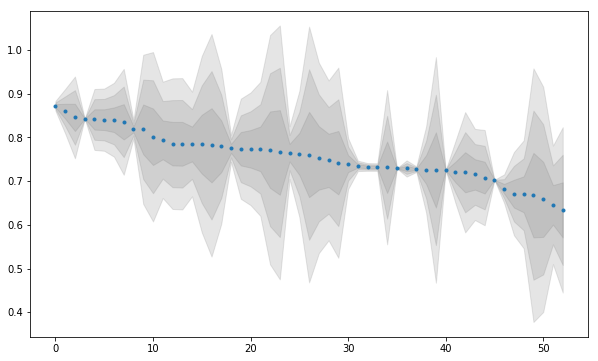

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
avs = av_kappas_df.loc[:,"Geral"].values
stds = std_kappas_df.loc[:,"Geral"].values
plt.plot(list(range(size)), avs, '.')
for n in np.linspace(3, 1, 3):
    plt.fill_between(list(range(size)), avs+n*stds, avs-n*stds, color='grey', alpha=0.2)

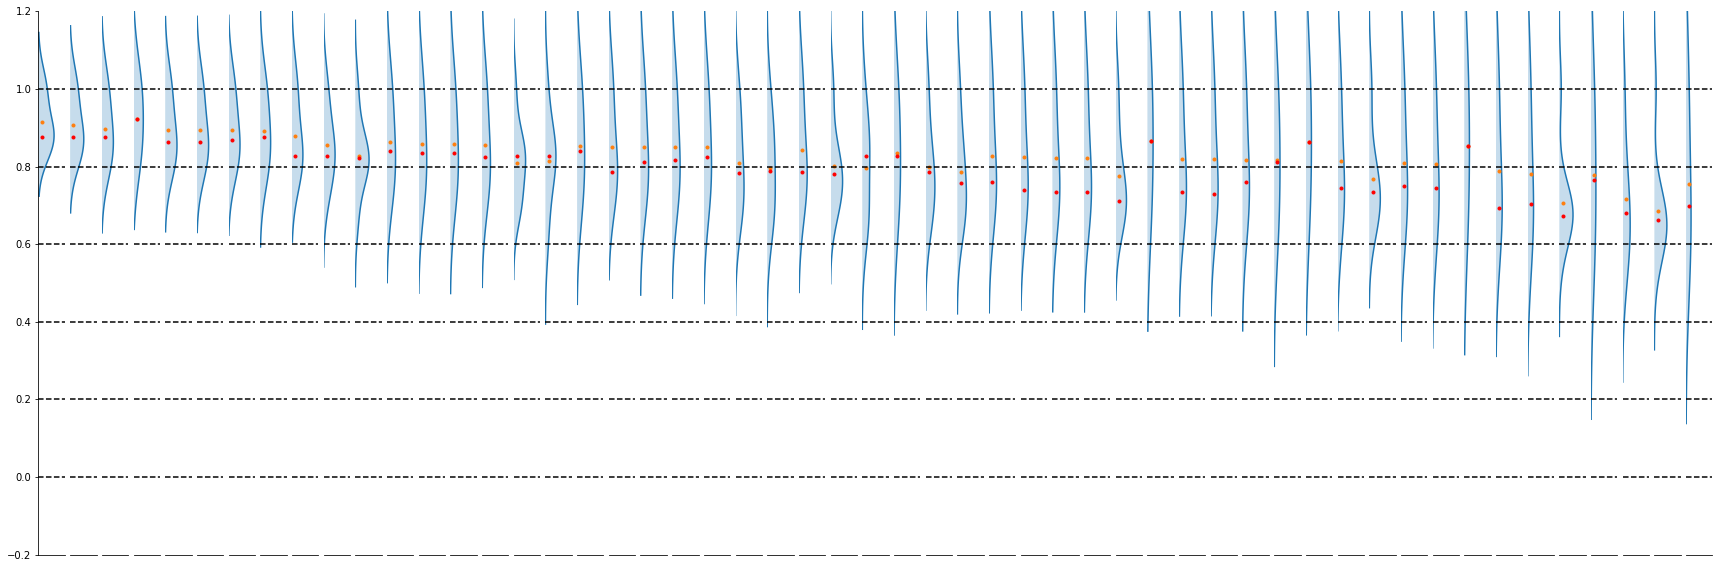

In [78]:
fig = plt.figure(figsize=(30,10))

av_kappas_df.sort_values("Geral", ascending=False, inplace=True)

new_order = av_kappas_df.index

reorganize_kappa = kappa_matrix[:, new_order, 0][new_order]

for n in range(reorganize_kappa.shape[0]):
    linha = reorganize_kappa[n,:]
    linha = linha[linha==linha]

    ax = plt.subplot(1, reorganize_kappa.shape[0], n+1)
    ax.set_xlim([0.0, 8.0])
    ax.set_ylim([-0.2, 1.2])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    sns.kdeplot(linha, vertical=True, shade=True)
    ax.get_xaxis().set_ticks([])
    if n > 0:
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_ticks([])
    ax.plot(1.0, linha.mean(), '.')
    ax.plot(1.0, np.median(linha), 'r.')
    
    ax.plot(np.linspace(0, 10, 100), np.ones((100, 1)), 'k--')
    ax.plot(np.linspace(0, 10, 100), 0.8*np.ones((100, 1)), 'k--')
    ax.plot(np.linspace(0, 10, 100), 0.6*np.ones((100, 1)), 'k--')
    ax.plot(np.linspace(0, 10, 100), 0.4*np.ones((100, 1)), 'k--')
    ax.plot(np.linspace(0, 10, 100), 0.2*np.ones((100, 1)), 'k--')
    ax.plot(np.linspace(0, 10, 100), np.zeros((100, 1)), 'k--')

# Calculando percentual médio de concordância

In [79]:
# Criando a lista com as percentagens médias
av_concord = list()

for n, s in enumerate(students):
    
    k = list()
    
    for i, l in enumerate(labels):
    
        # Pegando a n-ésima linha da matriz de percentagens com a label i
        ccs = percent_matrix[n, :, i]
  
        # Removendo o próprio anotador
        ccs = np.delete(ccs, n)
        
        # Calculando a percentagem média (tira todos os 0s da linha)
        k.append(ccs[(ccs == ccs)].mean())
    
    # Populando a lista de percentagens médias
    av_concord.append(
        (students[n], ) + tuple(k)
    ) 

# Dataframe de percentagens médias
av_concord_df = pd.DataFrame(data=av_concord, columns=['anotador'] + labels)

# Organizando por percentagem média geral
av_concord_df.sort_values('Geral', ascending=False, inplace=True)

# Vendo as maiores percentagens
av_concord_df.head(20)

,anotador,Geral,Doutrina,Precedente,Pessoa,Ref. Legislativa
8,181300026,0.909510,0.973126,0.865049,0.818618,0.880894
10,181300014,0.899902,0.996556,0.869972,0.786606,0.891418
51,171300011,0.889803,0.996622,0.872708,0.736620,0.887077
2,181300904,0.886118,0.951848,0.854960,0.795480,0.884526
27,181300052,0.885772,0.968483,0.882498,0.502952,0.853040
34,172300501,0.883447,0.939505,0.883179,0.675252,0.850486
49,181300072,0.882002,0.988733,0.812803,0.795550,0.865678
24,171300023,0.881740,0.977273,0.875951,0.779603,0.803259
20,181300004,0.874279,0.952713,0.823357,0.803558,0.826891
11,181300055,0.868698,0.966663,0.834471,0.791543,0.873852


In [80]:
#av_concord_df.to_csv('treino2_concordancia_pratica.csv', index=False)

## Distribuição de Concordância

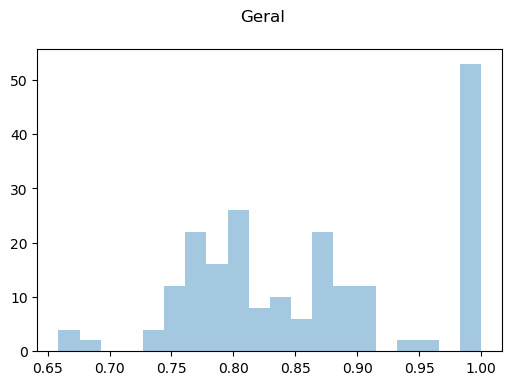

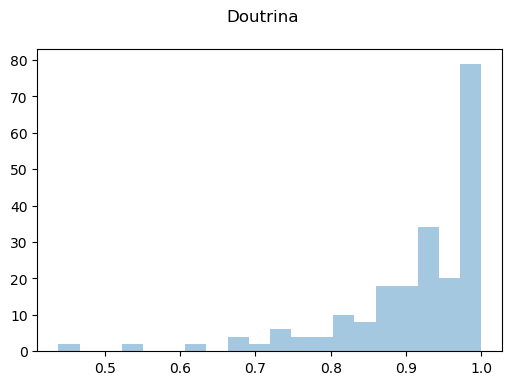

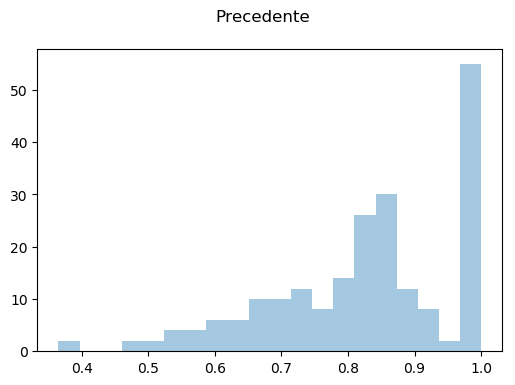

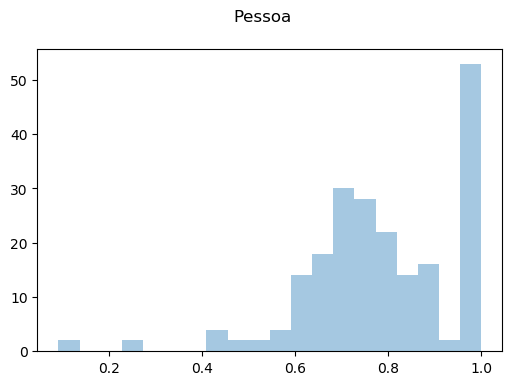

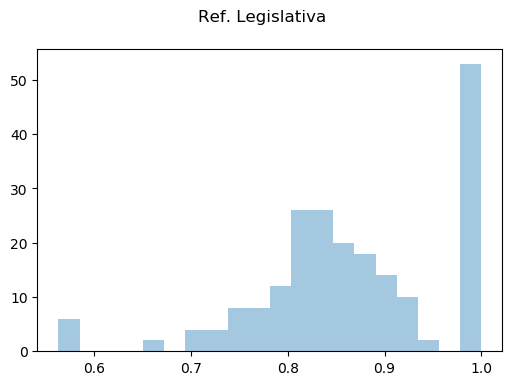

In [81]:
for i, l in enumerate(labels):
    
    fig, ax = plt.subplots(figsize=(6,4), dpi=100)
    
    sns.distplot(
        percent_matrix[:,:,i][percent_matrix[:,:,i] == percent_matrix[:,:,i]],
        kde=False,
        bins=20,
        ax=ax
    )
    plt.suptitle(l)
    plt.show()
    

## Como mudaria o visual das percentagens se reorganizássemos?

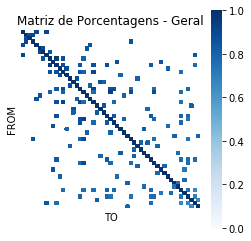

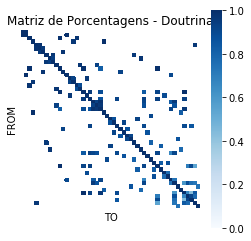

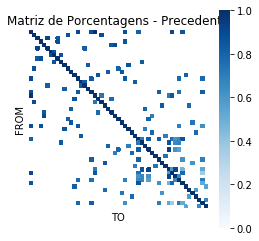

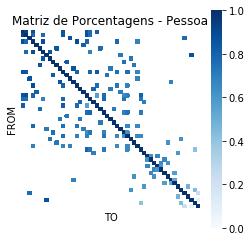

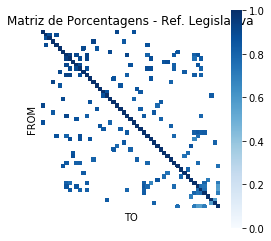

In [82]:
for i, l in enumerate(labels):
    # Plotando a matriz de percentagens
    # Abrindo a figura e o eixo
    fig, ax = plt.subplots(figsize=(4,4))

    av_concord_df.sort_values(l, ascending=False, inplace=True)

    new_order = av_concord_df.index
    
    reorganize_percent = percent_matrix[:, new_order, i][new_order]
    
    # Desenhando o heatmap
    # sns.heatmap(kappa_matrix, annot=True, ax=ax, xticklabels=ticks, yticklabels=ticks, square=True, cmap='Blues')
    sns.heatmap(reorganize_percent[:, :], annot=False, ax=ax, xticklabels=[], yticklabels=[], square=True, cmap='Blues', vmin=0)

    # Definindo título dos eixos
    ax.set_title('Matriz de Porcentagens - ' + l)
    ax.set_ylabel('FROM')
    ax.set_xlabel('TO')

    #Mostrando o gráfico
    plt.show()

## Vendo a estatística das percentagens

In [83]:
# Criando a lista com as percentagens std
std_concord = list()

for n, s in enumerate(students):
    
    k = list()
    
    for i, l in enumerate(labels):
        
        # Pegando a n-ésima linha da matriz de percentagens com a label i
        ccs = percent_matrix[n, :, i]
                
        # Removendo o próprio anotador
        ccs = np.delete(ccs, n)
        
        # Calculando desvio padrão da percentagem 
        k.append(ccs[(ccs == ccs)].std())
        
    # Populando a lista de percentagens std
    std_concord.append(
        (students[n], ) + tuple(k)
    ) 

# Dataframe de percentagens std
std_concord_df = pd.DataFrame(data=std_kappas, columns=['anotador'] + labels)

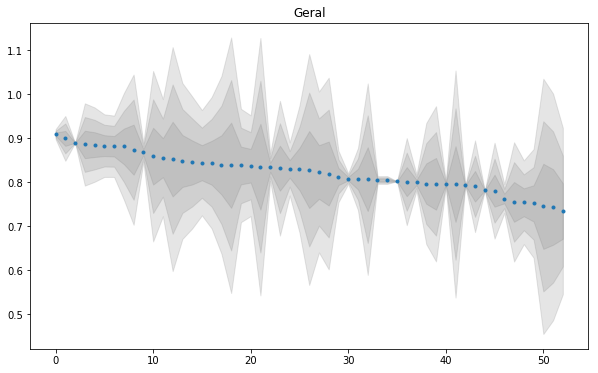

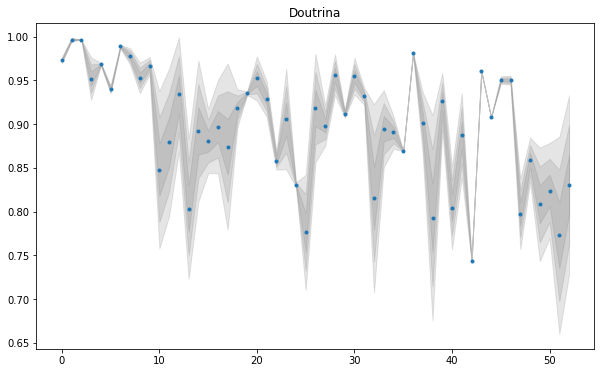

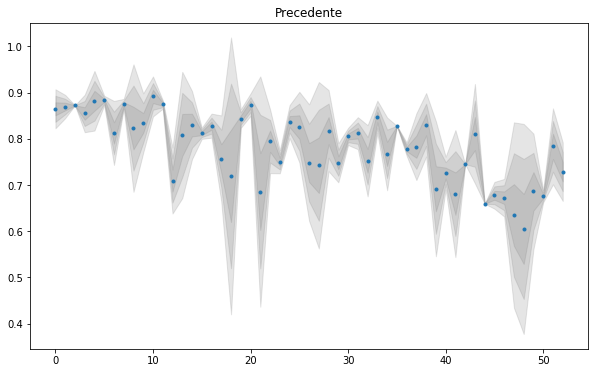

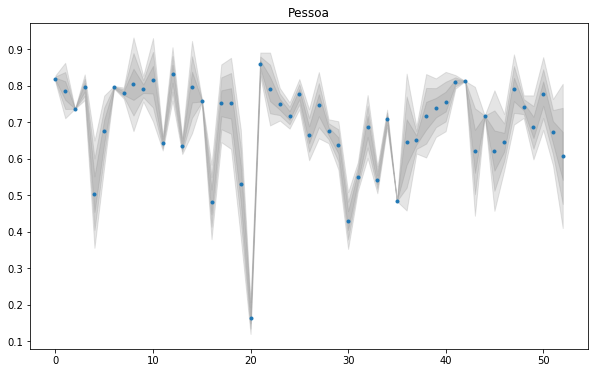

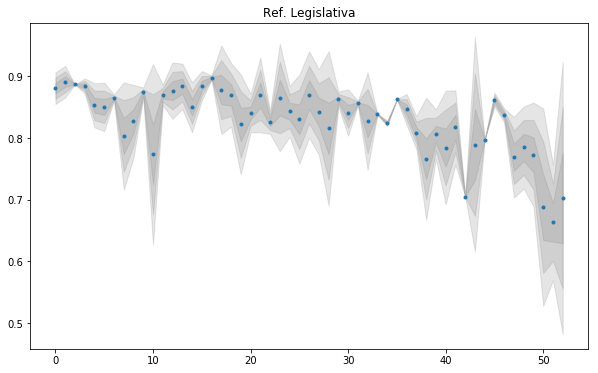

In [84]:
# Gráficos de médias por label

# Pegando as médias na ordem do label geral
av_concord_df.sort_values('Geral', ascending=False, inplace=True)

# Organizando os desvios padrões
std_concord_df = std_concord_df.loc[av_concord_df.index, :]

for i, l in enumerate(labels):
    fig, ax = plt.subplots(figsize=(10,6))
    avs = av_concord_df.loc[:,l].values
    stds = std_concord_df.loc[:,l].values
    
    ax.set_title(l)
    plt.plot(list(range(size)), avs, '.')
    
    for n in np.linspace(3, 1, 3):
        plt.fill_between(list(range(size)), avs+n*stds, avs-n*stds, color='grey', alpha=0.2)

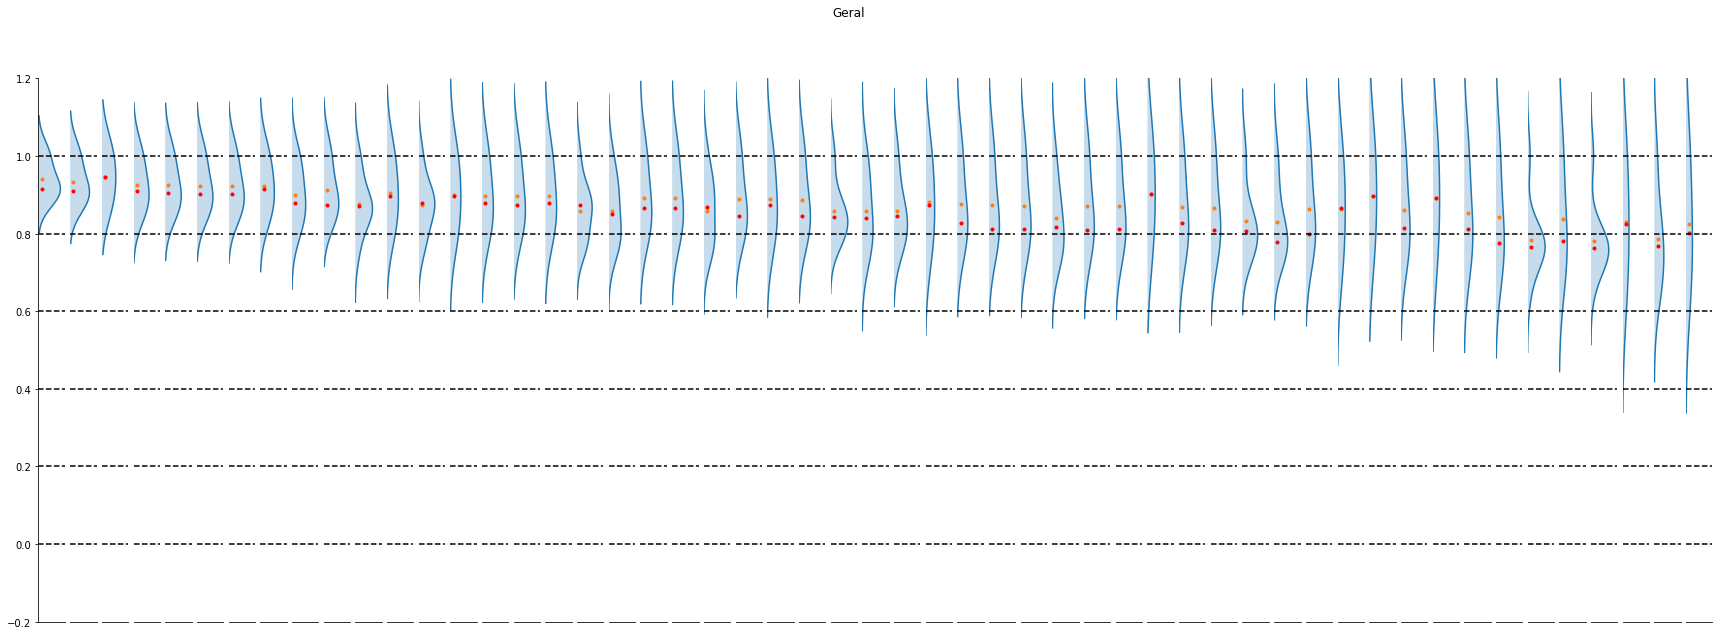

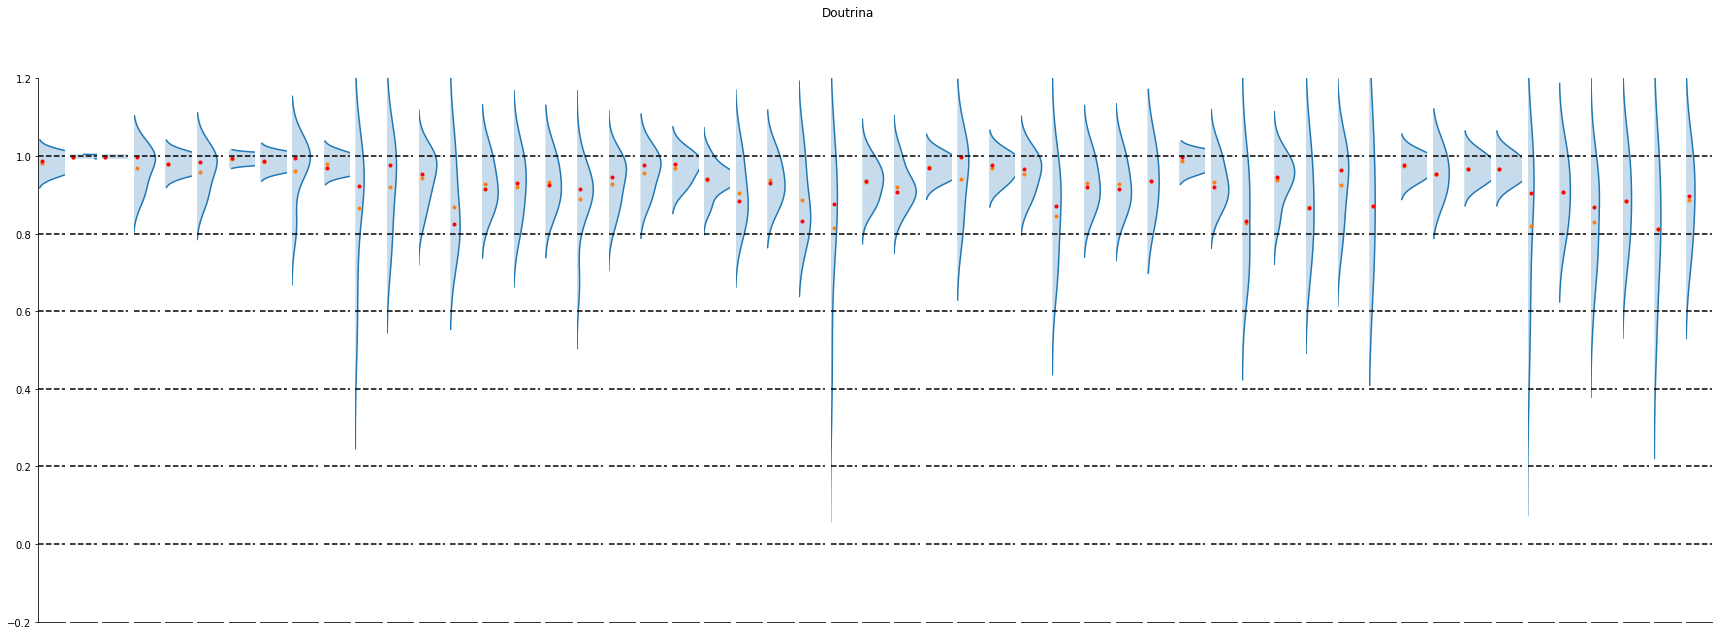

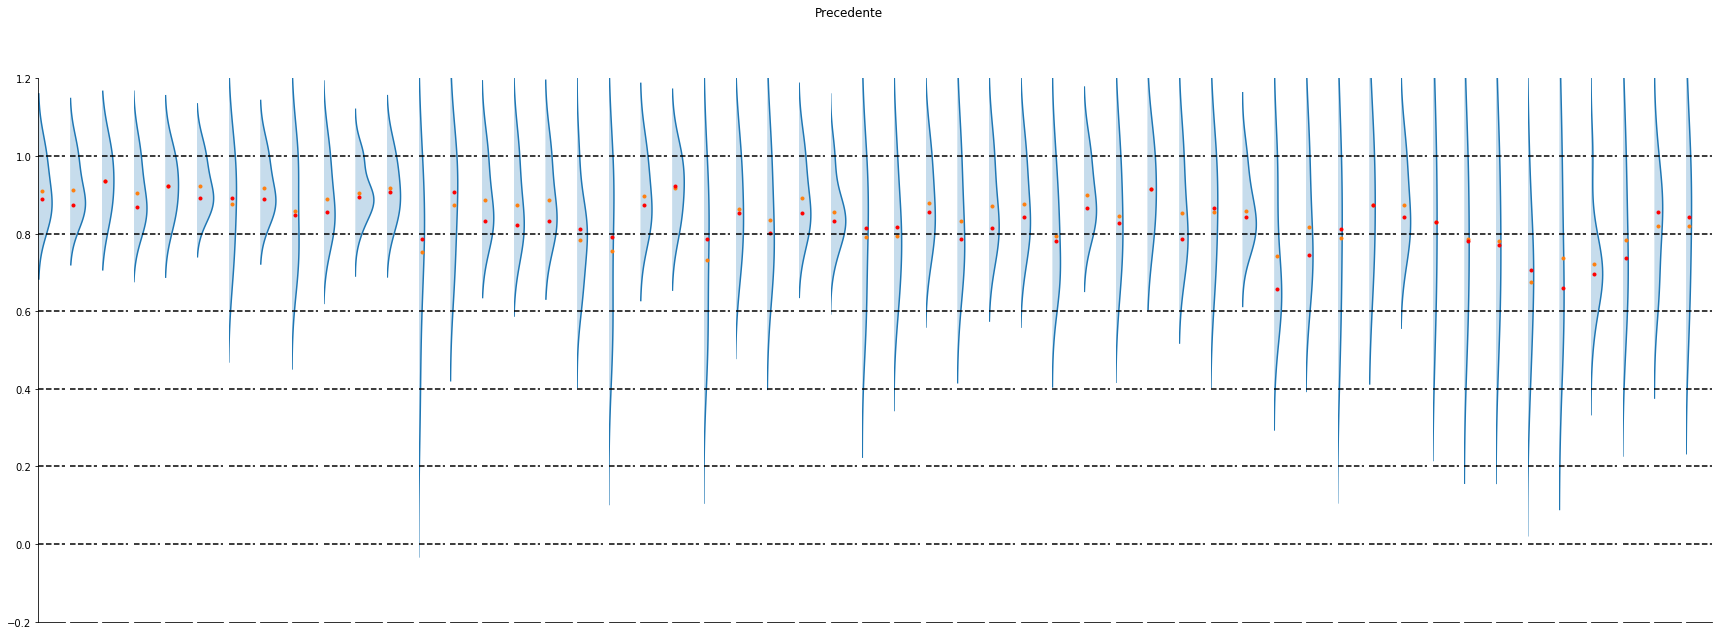

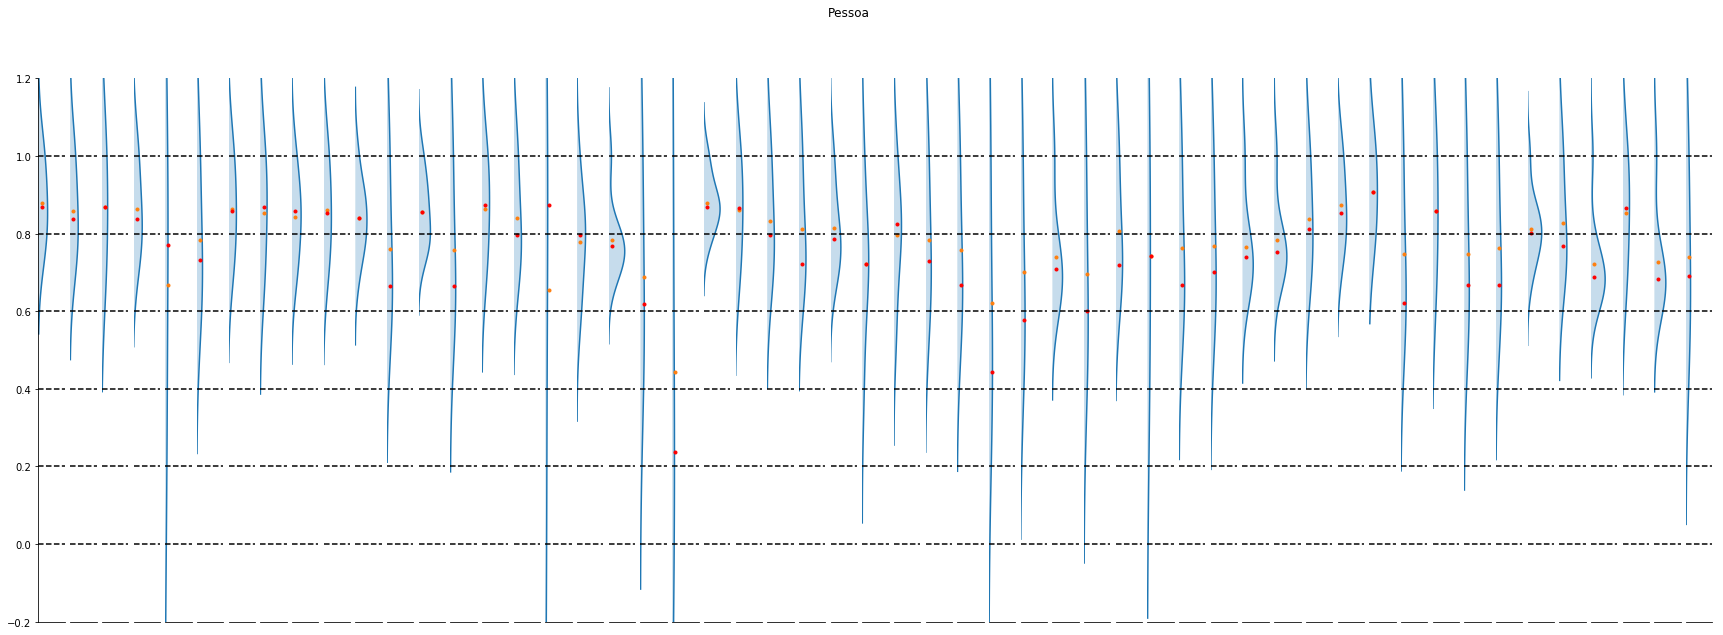

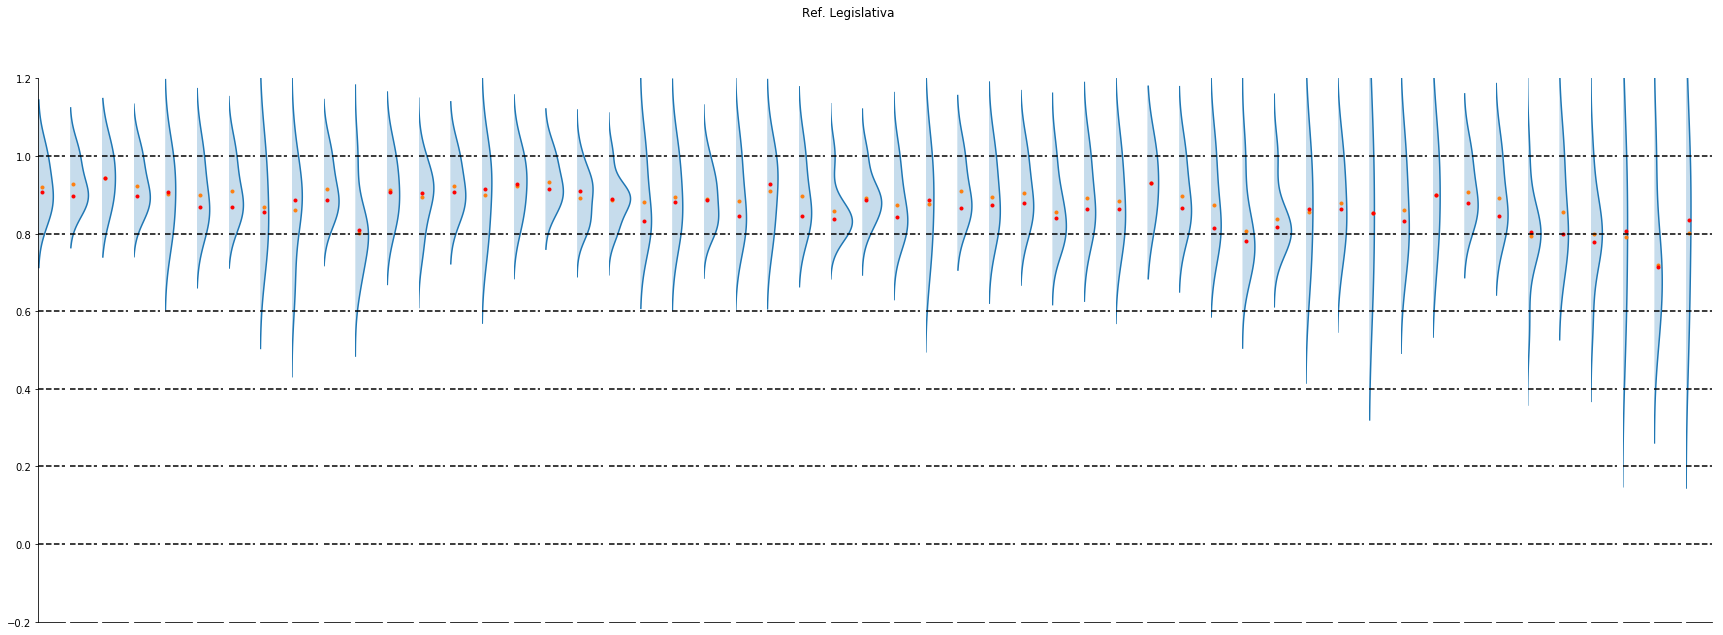

In [86]:
new_order = av_concord_df.index

for i, l in enumerate(labels):
    fig = plt.figure(figsize=(30,10))
    plt.suptitle(l)

    reorganize_percent = percent_matrix[:, new_order, i][new_order]
    
#     if np.isnan(reorganize_percent).sum() > 0:
#         reorganize_percent = np.nan_to_num(reorganize_percent)
#         print("Is NaN")
    
#     if (reorganize_percent.sum(axis=0) == 0).sum() > 0:
#         location = np.where(reorganize_percent.sum(axis=0) == 0)
#         reorganize_percent = np.delete(reorganize_percent, location, axis=0)
#         reorganize_percent = np.delete(reorganize_percent, location, axis=1)
#         print("Is Singular")
    
    for n in range(reorganize_percent.shape[0]):
        linha = reorganize_percent[n,:]
        linha = linha[linha==linha]
        
        
        ax = plt.subplot(1, reorganize_percent.shape[0], n+1)
        ax.set_xlim([0.0, 8.0])
        ax.set_ylim([-0.2, 1.2])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        sns.kdeplot(linha, vertical=True, shade=True)
        ax.get_xaxis().set_ticks([])
        if n > 0:
            ax.spines['left'].set_visible(False)
            ax.get_yaxis().set_ticks([])
        ax.plot(1.0, linha.mean(), '.')
        ax.plot(1.0, np.median(linha), 'r.')

        ax.plot(np.linspace(0, 10, 100), np.ones((100, 1)), 'k--')
        ax.plot(np.linspace(0, 10, 100), 0.8*np.ones((100, 1)), 'k--')
        ax.plot(np.linspace(0, 10, 100), 0.6*np.ones((100, 1)), 'k--')
        ax.plot(np.linspace(0, 10, 100), 0.4*np.ones((100, 1)), 'k--')
        ax.plot(np.linspace(0, 10, 100), 0.2*np.ones((100, 1)), 'k--')
        ax.plot(np.linspace(0, 10, 100), np.zeros((100, 1)), 'k--')

    plt.show()

# Output da matriz de Concordância

In [87]:
for i, l in enumerate(labels):

    
    df_concord = pd.DataFrame(
        data=percent_matrix[:,:,i],
        columns=students,
        index=students
    )

    #df_concord.to_csv(f'treino2_concordancia_anotadores_{l}.csv', index=True)

# Confusão entre labels

In [88]:
def confusion_labels_by_student(dataframe):
    """
    Função para matriz de confusão de labels por aluno
    """
    labelas = ['O', 'Doutrina', 'Precedente', 'Pessoa', 'Ref. Legislativa']
    tam = len(labelas)
    
    y1 = dataframe.Tag1.values
    y2 = dataframe.Tag2.values
    
    # Calculando matriz de confusão
    label_conf_l = sklearn.metrics.confusion_matrix(y1, y2, labels=labelas)
    
    # Como só quero saber quantas vezes eu tive pareamento entre dois labels,
    # vamos somar a parte acima e abaixo da diagonal
    for n in range(tam):
        for m in range(n+1, tam):
            label_conf_l[n,m] = label_conf_l[n,m] + label_conf_l[m,n]
            label_conf_l[m,n] = label_conf_l[n,m]
    
    return label_conf_l

In [89]:
# Inicializando as variáveis na memória onde salvar os resultados

label_matrix = np.zeros((len(labels), len(labels)))

# Percorrendo todos os possíveis pares de alunos
for n in tqdm.tqdm_notebook(range(size)):
    for m in range(n+1, size):     
        
        # checando se há overlap entre eles
        df_pair = df_overlap.query('anotador_x == @students[@n] and anotador_y == @students[@m]')
        
        # Se não houve overlap pular par
        if df_pair.shape[0] == 0:
            continue
            
        # Inicializando dataframe com tags
        df_tags = pd.DataFrame()
            
        # Iterando sobre overlap
        for i, row in df_pair.iterrows():
            
            # Pegando nome dos arquivos
            filename1 = row['arquivo_x']
            filename2 = row['arquivo_y']

            # Pegando os arquivos de anotação com aquele nome
            df1_temp = pd.read_csv(filename1, delimiter=';', na_values='NaN')
            df1_temp.replace(mapping, inplace=True)
            df2_temp = pd.read_csv(filename2, delimiter=';', na_values='NaN')
            df2_temp.replace(mapping, inplace=True)
            # Criando coluna com tag do segundo anotador
            df1_temp['Tag2'] = df2_temp.Tag
            
            # Mantendo apenas tag anotados por ao menos um dos anotadores
            df1_temp.query('Tag != "O" or Tag2 != "O"', inplace=True)
            df1_temp.columns = ['Token', 'Tag1', 'Tag2']

            # Concatenando o vetor de tags da vez com os antigos
            df_tags = pd.concat([df_tags, df1_temp])  
            
        # Limpando possíveis erros nas tags
        df_tags.dropna(inplace=True)
               
        df_tags.replace(
            {
                'B_Precedente': 'Precedente',
                'I_Precedente': 'Precedente',
                'B_Pessoa': 'Pessoa',
                'I_Pessoa': 'Pessoa',
                'B_Ref. Legislativa': 'Ref. Legislativa',
                'I_Ref. Legislativa': 'Ref. Legislativa',
                'B_Doutrina': 'Doutrina',
                'I_Doutrina': 'Doutrina'
            },
            inplace=True
            )
        
        # Calculando as concordâncias caso hajam arquivos em comum
        conf_by_student = confusion_labels_by_student(df_tags)
        
        # Somando as confusões de todos os alunos
        label_matrix = label_matrix + conf_by_student

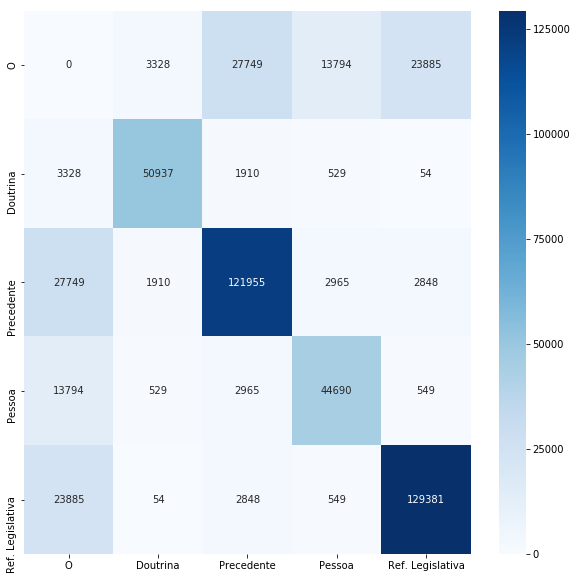

In [90]:
fig, ax = plt.subplots(figsize=(10,10))

labelas = ['O', 'Doutrina', 'Precedente', 'Pessoa', 'Ref. Legislativa']

sns.heatmap(label_matrix, cmap="Blues", xticklabels=labelas,
            yticklabels=labelas, annot=True, fmt='g')

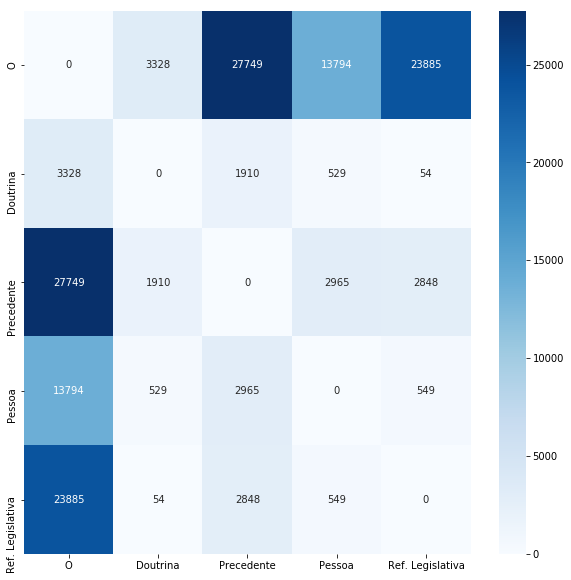

In [91]:
fig, ax = plt.subplots(figsize=(10,10))

new_label_matrix = label_matrix.copy()

new_label_matrix[1,1] = 0
new_label_matrix[2,2] = 0
new_label_matrix[3,3] = 0
new_label_matrix[4,4] = 0

sns.heatmap(new_label_matrix, cmap="Blues", xticklabels=labelas,
            yticklabels=labelas, annot=True, fmt='g')

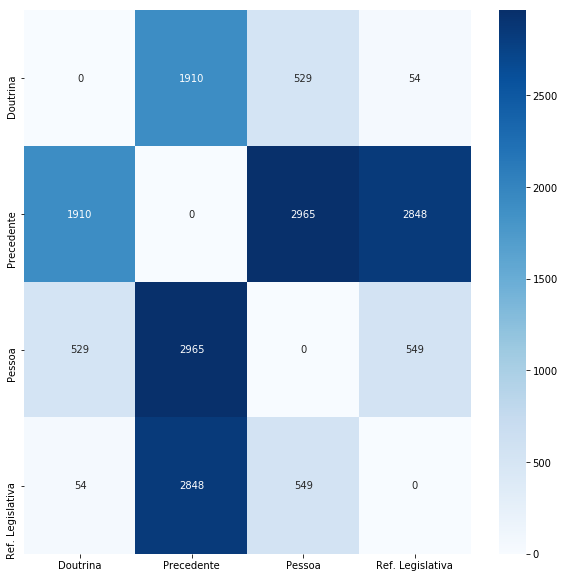

In [92]:
fig, ax = plt.subplots(figsize=(10,10))

new_label_matrix = label_matrix.copy()

new_label_matrix[1,1] = 0
new_label_matrix[2,2] = 0
new_label_matrix[3,3] = 0
new_label_matrix[4,4] = 0

sns.heatmap(new_label_matrix[1:, 1:], cmap="Blues", xticklabels=labelas[1:],
            yticklabels=labelas[1:], annot=True, fmt='g')

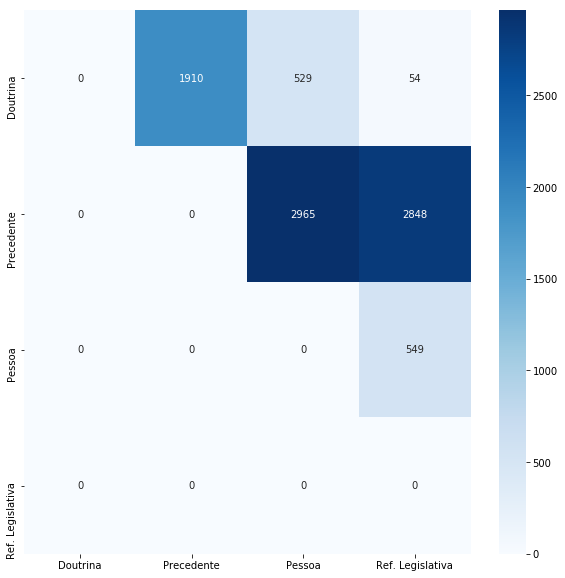

In [93]:
fig, ax = plt.subplots(figsize=(10,10))

new_label_matrix = np.triu(label_matrix, k=1)


sns.heatmap(new_label_matrix[1:,1:], cmap="Blues", xticklabels=labelas[1:],
            yticklabels=labelas[1:], annot=True, fmt='g')